In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

<h2>Preprocessing </h2>

<h3>Correlation-based feature selection</h3>


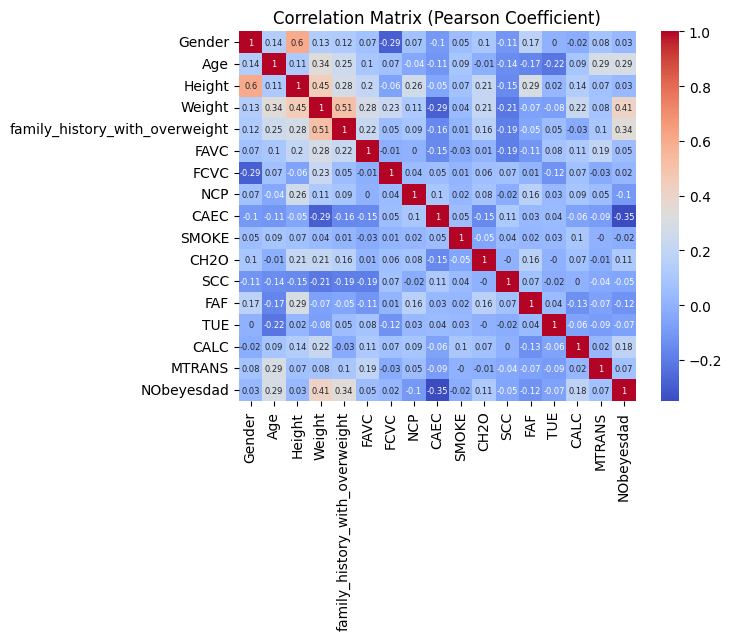

In [10]:
df = pd.read_csv("Data/DataEncoded.csv")
correlation = df.corr().round(2)
sns.heatmap(correlation, annot=True, cmap = 'coolwarm', annot_kws={'size': 6})
plt.title("Correlation Matrix (Pearson Coefficient)")
plt.show()

<h2> After Model Selection </h2>

<h3>Entropy / Information Gain</h3>

<h3>Gini Index</h3>

<h3>Backward Elimination</h3>